# Malicious URL Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings

In [3]:
df = pd.read_csv('../Datasets/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
df.shape

(651191, 2)

In [5]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

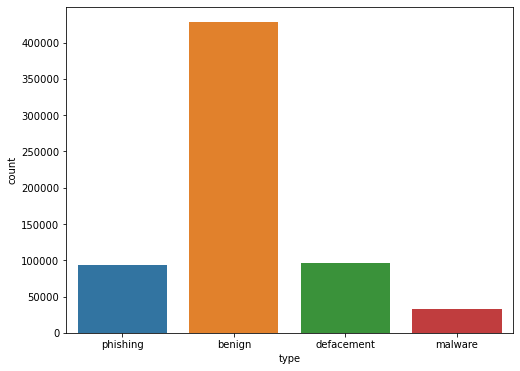

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='type');

## Feature Extraction

In [7]:
import whois
from datetime import datetime, timezone
import math
from pyquery import PyQuery
from requests import get
from interruptingcow import timeout
from tqdm import tqdm

In [8]:
df.iloc[3].url

'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15'

In [9]:
example_url = 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15'

In [10]:
domain = example_url.split('//')[-1].split('/')[0]
domain

'www.garage-pirenne.be'

Testing Whois Library

In [14]:
whois.whois("google.com")

{'domain_name': ['GOOGLE.COM', 'google.com'],
 'registrar': 'MarkMonitor, Inc.',
 'whois_server': 'whois.markmonitor.com',
 'referral_url': None,
 'updated_date': datetime.datetime(2019, 9, 9, 15, 39, 4),
 'creation_date': [datetime.datetime(1997, 9, 15, 4, 0),
  datetime.datetime(1997, 9, 15, 7, 0)],
 'expiration_date': [datetime.datetime(2028, 9, 14, 4, 0),
  datetime.datetime(2028, 9, 13, 7, 0)],
 'name_servers': ['NS1.GOOGLE.COM',
  'NS2.GOOGLE.COM',
  'NS3.GOOGLE.COM',
  'NS4.GOOGLE.COM',
  'ns3.google.com',
  'ns1.google.com',
  'ns4.google.com',
  'ns2.google.com'],
 'status': ['clientDeleteProhibited https://icann.org/epp#clientDeleteProhibited',
  'clientTransferProhibited https://icann.org/epp#clientTransferProhibited',
  'clientUpdateProhibited https://icann.org/epp#clientUpdateProhibited',
  'serverDeleteProhibited https://icann.org/epp#serverDeleteProhibited',
  'serverTransferProhibited https://icann.org/epp#serverTransferProhibited',
  'serverUpdateProhibited https://ica

In [15]:
response = get("https://google.com")
pq = PyQuery(response.text)

In [20]:
class UrlFeaturizer(object):
    def __init__(self, url):
        self.url = url
        self.domain = url.split('//')[-1].split('/')[0]
        self.today = datetime.now().replace(tzinfo=None)

        try:
            self.whois = whois.query(self.domain).__dict__
        except:
            self.whois = None

        try:
            self.response = get(self.url)
            self.pq = PyQuery(self.response.text)
        except:
            self.response = None
            self.pq = None

    def entropy(self):
        string = self.url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy

    def ip(self):
        string = self.url
        flag = False
        if ("." in string):
            elements_array = string.strip().split(".")
            if(len(elements_array) == 4):
                for i in elements_array:
                    if (i.isnumeric() and int(i)>=0 and int(i)<=255):
                        flag=True
                    else:
                        flag=False
                        break
        if flag:
            return 1 
        else:
            return 0

    def numDigits(self):
        digits = [i for i in self.url if i.isdigit()]
        return len(digits)

    def urlLength(self):
        return len(self.url)

    def numParameters(self):
        params = self.url.split('&')
        return len(params) - 1

    def numFragments(self):
        fragments = self.url.split('#')
        return len(fragments) - 1

    def numSubDomains(self):
        subdomains = self.url.split('http')[-1].split('//')[-1].split('/')
        return len(subdomains)-1

    def domainExtension(self):
        ext = self.url.split('.')[-1].split('/')[0]
        return ext

    ## URL domain features
    def hasHttp(self):
        return 'http:' in self.url

    def hasHttps(self):
        return 'https:' in self.url

    def daysSinceRegistration(self):
        if self.whois and self.whois['creation_date']:
            diff = self.today - self.whois['creation_date'].replace(tzinfo=None)
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0

    def daysSinceExpiration(self):
        if self.whois and self.whois['expiration_date']:
            diff = self.whois['expiration_date'].replace(tzinfo=None) - self.today
            diff = str(diff).split(' days')[0]
            return diff
        else:
            return 0
    
     ## URL Page Features
    def bodyLength(self):
        if self.pq is not None:
            return len(self.pq('html').text()) if self.urlIsLive else 0
        else:
            return 0

    def numTitles(self):
        if self.pq is not None:
            titles = ['h{}'.format(i) for i in range(7)]
            titles = [self.pq(i).items() for i in titles]
            return len([item for s in titles for item in s])
        else:
            return 0

    def numImages(self):
        if self.pq is not None:
            return len([i for i in self.pq('img').items()])
        else:
            return 0

    def numLinks(self):
        if self.pq is not None:
            return len([i for i in self.pq('a').items()])
        else:
            return 0

    def scriptLength(self):
        if self.pq is not None:
            return len(self.pq('script').text())
        else:
            return 0

    def specialCharacters(self):
        if self.pq is not None:
            bodyText = self.pq('html').text()
            schars = [i for i in bodyText if not i.isdigit() and not i.isalpha()]
            return len(schars)
        else:
            return 0

    def scriptToSpecialCharsRatio(self):
        v = self.specialCharacters()
        if self.pq is not None and v!=0:
            sscr = self.scriptLength()/v
        else:
            sscr = 0
        return sscr

    def scriptTobodyRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            sbr = self.scriptLength()/v
        else:
            sbr = 0
        return sbr

    def bodyToSpecialCharRatio(self):
        v = self.bodyLength()
        if self.pq is not None and v!=0:
            bscr = self.specialCharacters()/v
        else:
            bscr = 0
        return bscr

    def urlIsLive(self):
        return self.response == 200

    def run(self):
        data = {}
        data['entropy'] = self.entropy()
        data['numDigits'] = self.numDigits()
        data['urlLength'] = self.urlLength()
        data['numParams'] = self.numParameters()
        data['hasHttp'] = self.hasHttp()
        data['hasHttps'] = self.hasHttps()
        data['urlIsLive'] = self.urlIsLive()
        data['bodyLength'] = self.bodyLength()
        data['numTitles'] = self.numTitles()
        data['numImages'] = self.numImages()
        data['numLinks'] = self.numLinks()
        data['scriptLength'] = self.scriptLength()
        data['specialChars'] = self.specialCharacters()
        data['ext'] = self.domainExtension()
        data['dsr'] = self.daysSinceRegistration()
        data['dse'] = self.daysSinceExpiration()
        data['sscr'] = self.scriptToSpecialCharsRatio()
        data['sbr'] = self.scriptTobodyRatio()
        data['bscr'] = self.bodyToSpecialCharRatio()
        data['num_%20'] = self.url.count("%20")
        data['num_@'] = self.url.count("@")
        data['has_ip'] = self.ip()
    
        return data

In [21]:
UrlFeaturizer('https://google.com').run()

{'entropy': -3.57243125132212,
 'numDigits': 0,
 'urlLength': 18,
 'numParams': 0,
 'hasHttp': False,
 'hasHttps': True,
 'urlIsLive': False,
 'bodyLength': 10658,
 'numTitles': 0,
 'numImages': 1,
 'numLinks': 27,
 'scriptLength': 8547,
 'specialChars': 3084,
 'ext': 'com',
 'dsr': 0,
 'dse': 0,
 'sscr': 2.7714007782101167,
 'sbr': 0.8019328204165885,
 'bscr': 0.28936010508538185,
 'num_%20': 0,
 'num_@': 0,
 'has_ip': 0}

In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
feature_df = pd.DataFrame()
for row in tqdm(df[:1000].iterrows()):
    try:
        temp = UrlFeaturizer(row[1].url).run()
        temp['target'] = row[1].type
        feature_df = feature_df.append(temp, ignore_index=True)
    except:
        print(row[0])

438it [04:40,  1.82it/s]

In [ ]:
feature_df

### References:
https://medium.com/nerd-for-tech/url-feature-engineering-and-classification-66c0512fb34d